In [1]:
!jt -t chesterish -T

# Import Libraries and Read files

## Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import strgen
import random
from censusname import Censusname
%config IPCompleter.greedy = True
path = os.getcwd()
os.listdir("C:\\Users\\chris\\OneDrive - Irwin's Safety and Industrial Labour Services Ltd\\Irwins\\output")

['.ipynb_checkpoints',
 '2013_2016.csv',
 'cec2018_unique_workers.csv',
 'cec_2018.csv',
 'daily.csv',
 'joffre_2018.csv',
 'multiple_areas.csv',
 'SB_analysis.csv',
 'SB_Histograms.xlsx',
 'sheerness_2017.csv',
 'shep_2018.csv',
 'simulation',
 'TA_database.csv',
 'TimeVsCode.xlsx',
 '~$TimeVsCode.xlsx']

## Rename Columns and Clean Inputs

In [3]:
path = "C:\\Users\\chris\\OneDrive - Irwin's Safety and Industrial Labour Services Ltd\\Irwins\\output"
# rename columns for consistent formatting.
colnames = ['csas_id', 'clean_date', 'entry_name', 'shift', 'crew_size', 'duration', 'facility_owner',
            'proj_name', 'proj_year', 'cause_code', 'time_phase', 'code_phase', 'person_hours',
            'work_order', 'vessel', 'facility', 'start_phase', 'start_time', 'stop_time', 'note', 'proj_id',
            'days_from_start', 'csa_per_day', 'work_start', 'code_timing', 'accountability', 'active',
            'work_occur', 'unique_entry']
all_proj = pd.read_csv(path+"\\TA_database.csv",
                       parse_dates=['work_start', 'start_time', 'stop_time'])
all_proj.columns = colnames

In [4]:
cec_2018 = all_proj.loc[(all_proj['proj_id'] ==
                         'Calgary Energy Centre_2018')].copy()
cec_2018.index.name = 'index_id'
# create a dictionary to pair inconsistent vessel names with consistent ones.  Correcting spelling,
# capitalization, etc.
vessel_old = list(cec_2018['vessel'].astype('str').unique())
vessel_old = sorted(vessel_old)
vessel_new = ['Blow Down Tank', 'CT Exhaust Duct', 'CT Exhaust Duct',
              'CT Generator', 'CT Generator Vault', 'CT Generator', 'CT Inlet Scroll',
              'Combustion Turbine Generator Vault', 'Combustion Turbine Generator Vault',
              'Combustor Shell', 'Condenser Hot Well Upper', 'Condenser Waterbox',
              'Condenser Waterbox', 'Cooling Tower', 'Cooling Tower Basin', 'Demin Storage',
              'Exhaust Door East', 'HP Steam Drum', 'HP Steam Drum', 'HP Steam Drum',
              'HRSG Gas Side East', 'HRSG HP Drum', 'HRSG LP Drum', 'HRSG Reheater',
              'HRSG', 'Hotwell Upper Access', 'HRSG', 'HRSG', 'HRSG Blowdown Tank', 'HRSG',
              'LP Drum', 'LP Drum', 'CT Inlet Scroll', 'LP Drum', 'Main Condensor', 'ST Generator',
              'ST Hotwell Upper Access ', 'Condenser Waterbox', 'STG Terminal Box', 'ST Generator', 'nan']
vessel_dict = {vessel_old[i]: vessel_new[i] for i in range(len(vessel_old))}
vessel_dict

{'Blow Down Tank': 'Blow Down Tank',
 'CT Exhaust Duct': 'CT Exhaust Duct',
 'CT Exhaust Duct East': 'CT Exhaust Duct',
 'CT Generator': 'CT Generator',
 'CT Generator Vault East': 'CT Generator Vault',
 'CT Generator Vault West': 'CT Generator',
 'CT Inlet Scroll': 'CT Inlet Scroll',
 'Combustion Turbine Generator Vault': 'Combustion Turbine Generator Vault',
 'Combustion Turbine Generator Vault East': 'Combustion Turbine Generator Vault',
 'Combustor Shell': 'Combustor Shell',
 'Condenser Hot Well Upper': 'Condenser Hot Well Upper',
 'Condenser Waterbox NW & NE': 'Condenser Waterbox',
 'Condensor Waterbox': 'Condenser Waterbox',
 'Cooling Tower': 'Cooling Tower',
 'Cooling Tower Basin': 'Cooling Tower Basin',
 'Demin Storage': 'Demin Storage',
 'Exhaust Door East': 'Exhaust Door East',
 'HP Drum East/West': 'HP Steam Drum',
 'HP Drum West': 'HP Steam Drum',
 'HP Steam Drum': 'HP Steam Drum',
 'HRSG Gas Side East': 'HRSG Gas Side East',
 'HRSG HP Drum': 'HRSG HP Drum',
 'HRSG LP Drum 

In [5]:
cec_2018['vessel_clean'] = cec_2018['vessel'].map(vessel_dict).copy()
cec_2018['vessel_clean'].fillna("Cooling Tower Basin", inplace=True)

In [6]:
# Combine vessel name and door number to uniquely identify work space
cec_2018['vessel_entry'] = cec_2018['vessel_clean']+": "+cec_2018['entry_name']
cec_2018['crew_size'].fillna(0, inplace=True)
cec_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111 entries, 19910 to 21020
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   csas_id          1111 non-null   int64         
 1   clean_date       1111 non-null   object        
 2   entry_name       1111 non-null   object        
 3   shift            1111 non-null   object        
 4   crew_size        1111 non-null   float64       
 5   duration         1111 non-null   float64       
 6   facility_owner   1111 non-null   object        
 7   proj_name        1111 non-null   object        
 8   proj_year        1111 non-null   int64         
 9   cause_code       595 non-null    object        
 10  time_phase       1111 non-null   object        
 11  code_phase       872 non-null    object        
 12  person_hours     1099 non-null   float64       
 13  work_order       1111 non-null   object        
 14  vessel           1099 non-null   ob

# Define features and functions

In [7]:
cec_2018_tool_time = cec_2018.loc[(cec_2018['proj_id'] == 'Calgary Energy Centre_2018') &
                                  (cec_2018['active'] == 'working')].copy()
cec_2018_tool_time.head()

,csas_id,clean_date,entry_name,shift,crew_size,duration,facility_owner,proj_name,proj_year,cause_code,...,days_from_start,csa_per_day,work_start,code_timing,accountability,active,work_occur,unique_entry,vessel_clean,vessel_entry
index_id,,,,,,,,,,,,,,,,,,,,,
19913,9363945241,2018-05-26,Door 51,Night,2.0,1.066667,Enmax,Calgary Energy Centre,2018,NaN,...,0,1,2018-05-26 20:26:00,PostStart,tool time,working,yes,21129601 #1,CT Generator,CT Generator: Door 51
19917,9363945241,2018-05-26,Door 51,Night,2.0,1.000000,Enmax,Calgary Energy Centre,2018,NaN,...,0,1,2018-05-26 20:26:00,PostStart,tool time,working,yes,21129601 #1,CT Generator,CT Generator: Door 51
19921,8941955605,2018-05-27,Door 50,Night,4.0,0.466667,Enmax,Calgary Energy Centre,2018,NaN,...,1,1,2018-05-27 20:13:00,PostStart,tool time,working,yes,21129601 #1,CT Generator,CT Generator: Door 50
19925,8941955605,2018-05-27,Door 50,Night,4.0,0.283333,Enmax,Calgary Energy Centre,2018,NaN,...,1,1,2018-05-27 20:13:00,PostStart,tool time,working,yes,21129601 #1,CT Generator,CT Generator: Door 50
19929,8941955605,2018-05-27,Door 50,Night,4.0,1.550000,Enmax,Calgary Energy Centre,2018,NaN,...,1,1,2018-05-27 20:13:00,PostStart,tool time,working,yes,21129601 #1,CT Generator,CT Generator: Door 50


## Add features to allow for worker selection logic

In [8]:
unique_workers = pd.read_csv(path+"\\cec2018_unique_workers.csv")
uw_key = list(unique_workers['clean_date'])
uw_value = list(unique_workers['WorkerId'])
uw_dict = {uw_key[i]: uw_value[i] for i in range(len(uw_key))}

In [9]:
cec_2018_tool_time['daily_required'] = cec_2018_tool_time['clean_date'].map(
    uw_dict).astype('int')
cec_2018_tool_time['crew_size'] = cec_2018_tool_time['crew_size'].astype('int')
cec_2018_tool_time['work_stop'] = cec_2018_tool_time.groupby(
    'csas_id')['stop_time'].transform('max')
cec_2018_tool_time = cec_2018_tool_time.sort_values(
    ['work_start', 'csas_id', 'start_time']).reset_index()
cec_2018_tool_time['csas_id_match'] = cec_2018_tool_time['csas_id'].eq(
    cec_2018_tool_time['csas_id'].shift())
cec_2018_tool_time['csas_id_entries'] = cec_2018_tool_time.groupby(
    'csas_id')['clean_date'].transform('count')
cec_2018_tool_time['next_csas_id_match'] = cec_2018_tool_time['csas_id_match'].shift(
    -1)

## Create Names from US Census Package

In [10]:
# Generate 20+ random names to populate a database.  Assumption is even if 31 workers doing jobs in a
# day, that they work on multiple work areas
name = Censusname()
first_name = []
last_name = []
company = []
companies = ['WeldingCorp1', 'WeldingCorp2',
             'LaborerCorp', 'MillwrightCorp1', 'MillwrightCorp2']
for i in range(28):
    first, last = name.generate(given='male').split(" ")
    first_name.append(first)
    last_name.append(last)
    company.append(random.choice(companies))

In [11]:
workers = pd.DataFrame(list(zip(first_name, last_name, company)), columns=[
                       'FirstName', 'LastName', 'Company'])
workers.index.name = 'workerid'
workers.head()

,FirstName,LastName,Company
workerid,,,
0,Johnny,Morgan,WeldingCorp1
1,Russell,Shadwick,WeldingCorp2
2,Howard,Grant,LaborerCorp
3,Manuel,Kanarek,LaborerCorp
4,John,Doyle,WeldingCorp1


## Get Workers Function

In [12]:
def get_workers(df, start, stop, num, daily_required):
    """ This function selects a number of workers from a list based on their availability.  
    Preference is given to certain workers who are assumed to be 'full time', while others
    work intermittently"""
    avail_worker_list = []
    # Number of workers needed that day
    daily_required = daily_required
    # Generated List.  Preference is give to workers who are full time (ie. higher on the list)
    all_workers = set(df.iloc[:daily_required, 0])
    # Workers currently busy
    unavail_workers = set(
        df.loc[(df.TimeOut > start) & (df.TimeIn < stop)]['WorkerId'])
    # Available workers
    avail = list(all_workers ^ unavail_workers)
    # select workers and then remove from available list to ensure no duplication
    for n in range(num):
        workerid = random.choice(avail)
        avail_worker_list.append(workerid)
        avail.remove(workerid)
    return avail_worker_list

## Get entries which simulate RFID Scans

In [13]:
def get_entries(start_list, indexid, csasid, start, end, csa_entries, unused):
    """Takes a list of available workers and assigns shifts that adhere to the constraints observed
    when the vessel was occupied and empty""" 
    # Unused list generated if workers must be selected to ensure unique workers in confined space
    # is honored
    if len(unused) > 0:
        num_workers = len(unused)
        avail_worker_list = list(unused)
        # Allow for more than just the "unused" workers be selected on the last entry event
        if len(unused) < len(start_list):
            num_workers = random.randint(len(unused), len(start_list))
            additional = list(set(avail_worker_list) ^ set(start_list))
            for i in range(len(unused), num_workers):
                avail_worker_list.append(additional.pop())
    else:
        # randomly select a number of workers
        num_workers = random.randint(1, len(start_list))
        avail_worker_list = start_list.copy()
    worker_list = []
    timein_list = []
    timeout_list = []
    return_list = []
    if num_workers == 1:
        workerid = random.choice(avail_worker_list)
        worker_list.append(workerid)
        timein_list.append(start)
        timeout_list.append(end)
    else:
        for i in range(num_workers):
            workerid = random.choice(avail_worker_list)
            worker_list.append(workerid)
            avail_worker_list.remove(workerid)
            # force first worker to be in for the duration of the entry event.
            if i == 0:
                timein_list.append(start)
                timeout_list.append(end)
            # allow other workers to enter and exit at random times
            else:
                timein_list.append(random.random() * (end - start)/2 + start)
                if i % 2 == 0:
                    timeout_list.append(end - datetime.timedelta(seconds=i*30*random.random()))
                else:
                    timeout_list.append(random.random() * (start - end)/2 + end)
    returndf = pd.DataFrame(list(zip(worker_list, timein_list, timeout_list)),
                            columns=['WorkerId', 'TimeIn', 'TimeOut'])
    returndf['index_id'] = indexid
    returndf['csas_id'] = csasid
    return_list.append(returndf)
    return_list.append(worker_list)
    return return_list

## Create a dataframe from which workers can be selected

In [14]:
eventscols = ['index_id', 'csas_id', 'TimeIn', 'TimeOut']
events = pd.DataFrame(columns=eventscols)
events['WorkerId'] = workers.index
events = events[['WorkerId', 'TimeIn', 'TimeOut', 'index_id', 'csas_id']]
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   WorkerId  28 non-null     int64 
 1   TimeIn    0 non-null      object
 2   TimeOut   0 non-null      object
 3   index_id  0 non-null      object
 4   csas_id   0 non-null      object
dtypes: int64(1), object(4)
memory usage: 1.2+ KB


# Simulate RFID Scans

In [15]:
for index, row in cec_2018_tool_time[cec_2018_tool_time['crew_size'] > 0].iterrows():
    if row['csas_id_match'] == False:
        avail_workers = get_workers(events, row['start_time'], row['work_stop'], row['crew_size'],
                                    row['daily_required'])
        used_workers_list = []
        unused = ""
    if row['next_csas_id_match'] == False:
        flat_list = [item for sublist in used_workers_list for item in sublist]
        unused = list(set(avail_workers) ^ set(flat_list))
    newevents, used_workers = get_entries(avail_workers, row['index_id'], row['csas_id'],
                                          row['start_time'], row['stop_time'], row['csas_id_entries'],
                                          unused)
    used_workers_list.append(used_workers)
    events = events.append(newevents)

# Evaluate Results

In [16]:
# Ensure that simulated crew match actual (for unique workers).  Sum of 'match' should be zero
workers_check = pd.DataFrame()
workers_check['simulated_crew_size'] = events.groupby('csas_id')['WorkerId'].nunique()
workers_check['actual_crew'] = cec_2018_tool_time.groupby('csas_id')['crew_size'].min()
workers_check['match'] = workers_check['simulated_crew_size']- workers_check['actual_crew']
workers_check.sum()

simulated_crew_size    373
actual_crew            374
match                   -1
dtype: int64

## Export to csv for analysis in PowerBI

In [17]:
events = events.dropna().reset_index(drop=True)
events = events[['WorkerId', 'TimeIn', 'TimeOut', 'index_id']]
events.index.name = 'eventid'
events.to_csv(path+'\\simulation\\rfid_simulation.csv')
workers.to_csv(path+"\\simulation\\workers.csv")
cec_2018.to_csv(path+"\\simulation\\cec_data.csv")
cec_2018_tool_time.to_csv(path+"\\simulation\\cec_data_tool_time.csv")

In [18]:
# events.index.name = 'ScanEventId'
# events.columns = ['WorkerId', 'TimeIn', 'TimeOut', 'FactIndexId']
# workers.index.name = 'WorkerId'
# cec_2018.index.name = 'FactIndexId'
# cec_2018.columns = ['WorkPackageId', 'Date', 'DoorName', 'Shift', 'CrewSize', 'Duration',
#        'FacilityOwner', 'FacilityName', 'Year', 'CauseCode', 'TimePhase',
#        'CodePhase', 'ManHours', 'WorkOrderId', 'Vessel', 'FacilityName2',
#        'StartPhase', 'StartTime', 'EndTime', 'Note', 'ProjectId',
#        'DaysFromStart', 'WorkPackagePerDay', 'DailyWorkStart', 'CodeTiming',
#        'Accountability', 'Active', 'WorkOccur', 'UniqueEntry',
#        'VesselClean', 'AreaName']
# # events.to_csv(path+'\\simulation\\rfid_simulation.csv')
# # workers.to_csv(path+"\\simulation\\workers.csv")
# # cec_2018.to_csv(path+"\\simulation\\cec_data.csv")

## Plot Histogram of Tool Time by Worker

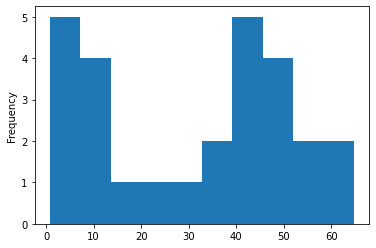

In [19]:
events['tool_time'] = (events.TimeOut-events.TimeIn).astype('timedelta64[s]')/3600
events.groupby('WorkerId').sum()['tool_time'].plot.hist()

## Check number of times a confined space had more than one work order

In [20]:
temp = cec_2018_tool_time.pivot_table(index=['clean_date'], columns=['vessel_entry'], values=['work_order'],
                                      aggfunc=lambda x: list(set(x)))
temp = temp.stack()
temp['unique_workorders'] = temp['work_order'].apply(lambda x: len(x))
temp[temp['unique_workorders'] > 1]

,,work_order,unique_workorders
clean_date,vessel_entry,,
2018-05-30,HRSG Gas Side East: Door 14,"[21118251, 21138284]",2
2018-06-11,CT Exhaust Duct: Door 48A,"[21098008, 21122364]",2
2018-06-12,Blow Down Tank: Door 25,"[21195481, 21145481]",2


# Evaluate Entries Per Day

## Add Man Hours to main dataframe

In [21]:
man_hours = pd.DataFrame(events.groupby('index_id')['tool_time'].sum())
man_hours.columns = ['man_hours']
cec_2018 = cec_2018.merge(man_hours, left_on='index_id',right_on = man_hours.index, how='left')

## Summarize Work Areas to determine what's suitable for remote scanning

In [22]:
work_coverage = (cec_2018.groupby('vessel_entry')[['clean_date', 'work_order',
                                                   'duration', 'crew_size','man_hours']].
                 agg({'clean_date': 'nunique', 'work_order': 'nunique',
                      'duration': 'sum', 'crew_size': 'mean','man_hours':'sum'}))
work_coverage['tool_time'] = (cec_2018[cec_2018['active'] == 'working'].
                              groupby('vessel_entry')['duration'].sum())
work_coverage.reset_index()
work_coverage.head()
work_coverage.columns = ['days', 'unique_wo',
                         'total_hours', 'average_crew', 'man_hours','tool_time']
work_coverage = work_coverage.sort_values(
    by=['tool_time'], ascending=False)
work_coverage['cum_tool_time_tt'] = work_coverage['tool_time'].cumsum(
)/work_coverage['tool_time'].sum()
work_coverage['cum_total_hours_tt'] = work_coverage['total_hours'].cumsum(
)/work_coverage['total_hours'].sum()
work_coverage['cum_man_hours_tt'] = work_coverage['man_hours'].cumsum(
)/work_coverage['man_hours'].sum()

work_coverage = work_coverage.sort_values(
    by=['total_hours'], ascending=False)
work_coverage['cum_tool_time_th'] = work_coverage['tool_time'].cumsum(
)/work_coverage['tool_time'].sum()
work_coverage['cum_total_hours_th'] = work_coverage['total_hours'].cumsum(
)/work_coverage['total_hours'].sum()
work_coverage['cum_man_hours_th'] = work_coverage['man_hours'].cumsum(
)/work_coverage['man_hours'].sum()

work_coverage = work_coverage.sort_values(
    by=['man_hours'], ascending=False)
work_coverage['cum_tool_time_mh'] = work_coverage['tool_time'].cumsum(
)/work_coverage['tool_time'].sum()
work_coverage['cum_total_hours_mh'] = work_coverage['total_hours'].cumsum(
)/work_coverage['total_hours'].sum()
work_coverage['cum_man_hours_mh'] = work_coverage['man_hours'].cumsum(
)/work_coverage['man_hours'].sum()

## Assign RFID Scanners to Work Areas

In [23]:
scan_keys = ['CT Generator: Door 51', 'CT Exhaust Duct: Door 48A', 'HRSG Gas Side East: Door 14',
                   'HP Steam Drum: Door 5/6', 'HP Steam Drum: Door 6', 'CT Generator Vault: Door 50',
                   'CT Inlet Scroll: Door 46', 'Cooling Tower Basin: Door 103',
                   'Cooling Tower Basin: Door 103/63', 'Cooling Tower Basin: Door 63/103',
                   'LP Drum: Door 2', 'LP Drum: Door 4']
scan_values = ['Scan Reader 1', 'Scan Reader 2', 'Scan Reader 3',
                     'Scan Reader 4', 'Scan Reader 4', 'Scan Reader 5',
                     'Scan Reader 6','Scan Reader 7', 'Scan Reader 7', 'Scan Reader 7',
                     'Scan Reader 8', 'Scan Reader 8']
scan_dict = {scan_keys[i]:scan_values[i] for i in range(len(scan_keys))}
scan_dict

{'CT Generator: Door 51': 'Scan Reader 1',
 'CT Exhaust Duct: Door 48A': 'Scan Reader 2',
 'HRSG Gas Side East: Door 14': 'Scan Reader 3',
 'HP Steam Drum: Door 5/6': 'Scan Reader 4',
 'HP Steam Drum: Door 6': 'Scan Reader 4',
 'CT Generator Vault: Door 50': 'Scan Reader 5',
 'CT Inlet Scroll: Door 46': 'Scan Reader 6',
 'Cooling Tower Basin: Door 103': 'Scan Reader 7',
 'Cooling Tower Basin: Door 103/63': 'Scan Reader 7',
 'Cooling Tower Basin: Door 63/103': 'Scan Reader 7',
 'LP Drum: Door 2': 'Scan Reader 8',
 'LP Drum: Door 4': 'Scan Reader 8'}

In [24]:
work_coverage['scan_reader'] = work_coverage.index.map(scan_dict)
work_coverage.to_csv(path+"\\simulation\\work_coverage.csv")
work_coverage.head(10)

,days,unique_wo,total_hours,average_crew,man_hours,tool_time,cum_tool_time_tt,cum_total_hours_tt,cum_man_hours_tt,cum_tool_time_th,cum_total_hours_th,cum_man_hours_th,cum_tool_time_mh,cum_total_hours_mh,cum_man_hours_mh,scan_reader
vessel_entry,,,,,,,,,,,,,,,,
HRSG Gas Side East: Door 14,9,3,64.666667,4.523810,117.942222,47.866667,0.233461,0.232791,0.263545,0.312775,0.334780,0.350713,0.113837,0.091033,0.140059,Scan Reader 3
CT Generator: Door 51,12,4,100.700000,3.522581,103.986111,50.300000,0.119624,0.141758,0.123486,0.119624,0.141758,0.123486,0.233461,0.232791,0.263545,Scan Reader 1
CT Exhaust Duct: Door 48A,10,3,72.450000,4.906250,73.403611,33.350000,0.394269,0.403829,0.426391,0.198938,0.243747,0.210654,0.312775,0.334780,0.350713,Scan Reader 2
HP Steam Drum: Door 6,8,3,49.050000,3.333333,63.728056,34.266667,0.314955,0.301839,0.339223,0.394269,0.403829,0.426391,0.394269,0.403829,0.426391,Scan Reader 4
CT Inlet Scroll: Door 46,5,2,32.033333,6.307692,61.337500,19.616667,0.440921,0.448923,0.499231,0.480796,0.513092,0.537939,0.440921,0.448923,0.499231,Scan Reader 6
HRSG: Door 8,2,1,19.700000,3.500000,32.855556,14.583333,0.587697,0.597813,0.629776,0.582702,0.603069,0.631503,0.475603,0.476655,0.538248,NaN
CT Generator Vault: Door 50,7,2,45.583333,2.523810,32.595556,16.766667,0.480796,0.513092,0.537939,0.434143,0.467998,0.465099,0.515478,0.540824,0.576956,Scan Reader 5
Hotwell Upper Access: Door 41A,2,2,14.133333,5.400000,31.604722,9.883333,0.669269,0.667144,0.711446,0.658449,0.670686,0.704929,0.538983,0.560720,0.614487,NaN
Cooling Tower Basin: Door 63/103,1,1,10.316667,7.000000,28.648889,8.966667,0.736256,0.713857,0.792372,0.785485,0.782014,0.830468,0.560308,0.575243,0.648508,Scan Reader 7


## Provide CSV to Islam

In [25]:
cec_2018_tool_time['scan_reader'] = cec_2018_tool_time['vessel_entry'].map(scan_dict)
islam_export = events.merge(cec_2018_tool_time[[
                            'index_id', 'clean_date','vessel_entry','scan_reader']], left_on='index_id', right_on='index_id', 
                            how='left')
islam_export = islam_export.merge(workers,left_on='WorkerId',right_on='workerid',how='left')
islam_export['scan_reader'].value_counts()

Scan Reader 2    84
Scan Reader 1    83
Scan Reader 3    69
Scan Reader 6    47
Scan Reader 4    40
Scan Reader 7    39
Scan Reader 5    33
Scan Reader 8    21
Name: scan_reader, dtype: int64

In [29]:
islam_export.to_csv(path+"\\simulation\\islam_data.csv")
islam_export.head()

,WorkerId,TimeIn,TimeOut,index_id,tool_time,clean_date,vessel_entry,scan_reader,FirstName,LastName,Company
0,0,2018-05-26 20:26:00.000000000,2018-05-26 21:30:00.000000000,19913,1.066667,2018-05-26,CT Generator: Door 51,Scan Reader 1,Johnny,Morgan,WeldingCorp1
1,1,2018-05-26 20:41:38.705627503,2018-05-26 21:21:48.830923883,19913,0.669444,2018-05-26,CT Generator: Door 51,Scan Reader 1,Russell,Shadwick,WeldingCorp2
2,0,2018-05-26 22:00:00.000000000,2018-05-26 23:00:00.000000000,19917,1.000000,2018-05-26,CT Generator: Door 51,Scan Reader 1,Johnny,Morgan,WeldingCorp1
3,1,2018-05-26 22:05:58.873903296,2018-05-26 22:40:41.319196493,19917,0.578333,2018-05-26,CT Generator: Door 51,Scan Reader 1,Russell,Shadwick,WeldingCorp2
4,0,2018-05-27 20:13:00.000000000,2018-05-27 20:41:00.000000000,19921,0.466667,2018-05-27,CT Generator: Door 50,NaN,Johnny,Morgan,WeldingCorp1


In [31]:
islam_export_2 = islam_export[['WorkerId','index_id', 'TimeIn', 'TimeOut', 'clean_date',
       'vessel_entry', 'scan_reader', 'FirstName', 'LastName', 'Company']]
islam_export_2 = islam_export_2.melt(id_vars=['WorkerId', 'clean_date','index_id',
       'vessel_entry', 'scan_reader', 'FirstName', 'LastName', 'Company']).sort_values(by='value')
islam_export_2.head()

,WorkerId,clean_date,index_id,vessel_entry,scan_reader,FirstName,LastName,Company,variable,value
0,0,2018-05-26,19913,CT Generator: Door 51,Scan Reader 1,Johnny,Morgan,WeldingCorp1,TimeIn,2018-05-26 20:26:00.000000000
1,1,2018-05-26,19913,CT Generator: Door 51,Scan Reader 1,Russell,Shadwick,WeldingCorp2,TimeIn,2018-05-26 20:41:38.705627503
610,1,2018-05-26,19913,CT Generator: Door 51,Scan Reader 1,Russell,Shadwick,WeldingCorp2,TimeOut,2018-05-26 21:21:48.830923883
609,0,2018-05-26,19913,CT Generator: Door 51,Scan Reader 1,Johnny,Morgan,WeldingCorp1,TimeOut,2018-05-26 21:30:00.000000000
2,0,2018-05-26,19917,CT Generator: Door 51,Scan Reader 1,Johnny,Morgan,WeldingCorp1,TimeIn,2018-05-26 22:00:00.000000000


In [33]:
islam_export_2.to_csv(path+"\\simulation\\islam_data2.csv",index=False)